<a href="https://colab.research.google.com/github/rachit2005/Large-Language-Model/blob/main/makemore_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Watch makemore -3 again --> "https://youtu.be/P6sfmUTpUmc?si=Wppot2wyJSZkKA4T"

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import requests
url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"
resp = requests.get(url)
words = resp.text.splitlines()

In [3]:
# building vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [4]:
# build dataset

block_size = 3

def build_dataset(words):
  x , y = [] , []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      x.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  x = torch.tensor(x)
  y = torch.tensor(y)
  print(x.shape , y.shape)
  return x , y

n1 , n2 = int(0.8*len(words)), int(0.9*len(words))
xtr , ytr = build_dataset(words[:n1])
xdev , ydev = build_dataset(words[n1:n2])
xtre , ytre = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


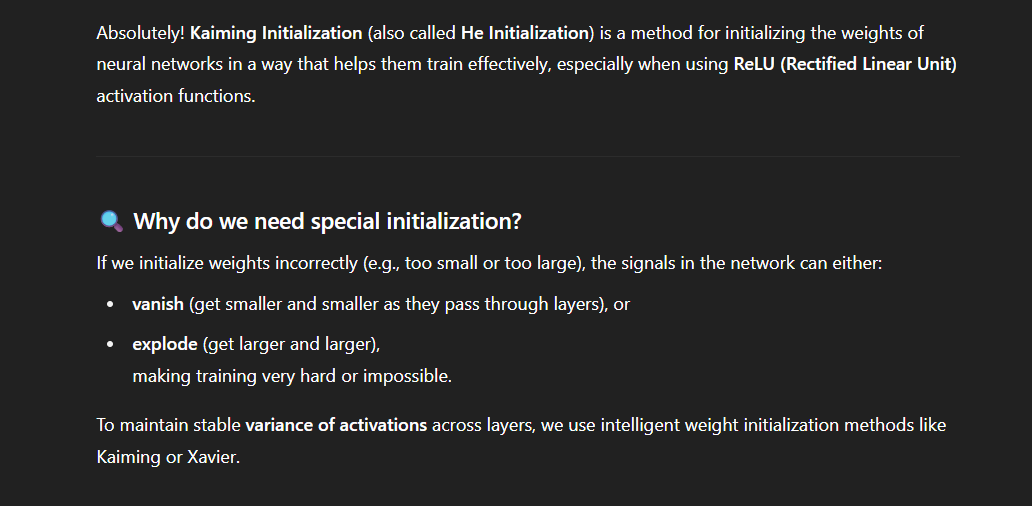

Try reading --> "http://research.google.com/pubs/archive/43442.pdf"

In [5]:
# mlp revisited --> to get better idea of how it works

n_emb =10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size , n_emb) , generator=g)
w1 = torch.randn((n_emb*block_size , n_hidden) , generator=g) * (5/3)/((n_emb*block_size)**0.5)

# when we are using batch normalization we can remove the b1 from it as it will not learn and it become useless and we going to use batch_normalisation_bias : batch_bias
# b1 = torch.randn(n_hidden , generator=g)*0.01
w2 = torch.randn((n_hidden , vocab_size) , generator=g) * 0.01 # to scale down the logits
b2 = torch.randn(vocab_size , generator=g)*0

batch_gain = torch.ones(n_hidden)
batch_bias = torch.zeros(n_hidden)
bnmean_running = torch.zeros(n_hidden)
bnstd_running = torch.ones(n_hidden)

parameters = [c,  w1,w2,b2 , batch_bias , batch_gain]
for p in parameters:
  p.requires_grad = True

In [25]:
epochs = 20000
batch_size = 32
losses = []

for i in range(epochs):
  # minibatches
  ix = torch.randint(0 , xtr.shape[0] , (batch_size,))
  xb , yb = xtr[ix] , ytr[ix]

  # forward pass
  emb = c[xb] #[batch_size , block_size , n_emb]
  print(emb.shape)
  flatten_layer = emb.view(emb.shape[0] , -1)
  print(flatten_layer.shape)
  # linear layer
  hpreact = flatten_layer @ w1 # + b1 # we want it to be in a guassian distribution
  '''------------------------------- for normalization -----------------------------------------'''
  bnmeani = hpreact.mean(0 , keepdim=True)
  bnstdi = hpreact.std(0 , keepdim=True)
  hpreact = batch_gain * ((hpreact - bnmeani)/ bnstdi) + batch_bias # batch normalization in 1 Dim
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # 0.001 is momentum we are using
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -----------------------------------------------------------------------------------------------
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ w2 + b2 # output layer

  loss = F.cross_entropy(logits , yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # gradient descent
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if i%1000 == 0:
    print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())
  break

plt.plot(losses)
plt.show()

torch.Size([32, 3, 10])
torch.Size([32, 30])


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [21]:
@torch.no_grad()

def split_loss(split):
  x,y = {
      'train': (xtr, ytr),
      'val': (xdev, ydev),
      'test': (xtre, ytre),
  }[split]
  emb = c[x]
  flatten_layer = emb.view(emb.shape[0] , -1)
  print(emb.shape)
  hpreact = flatten_layer@w1 # + b1
  hpreact = batch_gain * ((hpreact - bnmean_running)/ bnstd_running) + batch_bias # batch normalization
  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits , y)
  print(split , loss.item())

split_loss('train')
split_loss('val')

torch.Size([182778, 3, 10])
train 2.1423351764678955
torch.Size([22633, 3, 10])
val 2.405668020248413


In [9]:
# sample generation form the model

for _ in range(20):
  context = [0]*block_size
  out = []

  while True:
    # forward pass
    emb = c[torch.tensor([context])] #  [1 , block_size , n_emb]
    flatten_layer = emb.view(emb.shape[0] , -1)
    h = torch.tanh(flatten_layer @ w1)
    logits = h @ w2 + b2
    probs = F.softmax(logits , dim=1)
    # sample from distribution
    ix = torch.multinomial(probs , num_samples=1,).item()

    # shift the context window and track the sample
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

noxnncylandyn.
gsassryvenngrlynd.
shudvannlub.
del.
mbergnnxrof.
mabll.
mylan.
tzellartisssrezkassabrutreszang.
jkanz.
vesh.
xlandhbaslanmxkcrrvyky.
mox.
gbrnin.
demmezmssaran.
chedkmsa.
jmyralin.
gllanebriki.
athbrecharbdryssamm.
gvg.
jjly.


# Using Pytorch

In [26]:
class Linear:
  def __init__(self , fan_in , fan_out , bias=True):
    self.weights = torch.randn((fan_in , fan_out)) / (fan_in**0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, X):
    self.out = X @ self.weights
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1D:
  def __init__(self , dim , eps=1e-5 , momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # train with backpropagation
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,X):
    # cal forward pass
    if self.training:
      mean = X.mean(0, keepdim=True)
      std = X.std(0, keepdim=True)
    else:
      mean = self.running_mean
      std = self.running_var

    xhat = (X - mean)/torch.sqrt(std + self.eps) # normalise to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffer
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * std

    return self.out

  def parameters(self):
    return [self.gamma , self.beta]

class Tanh():
  def __call__(self , X):
    self.out = torch.tanh(X)
    return self.out

  def parameters(self):
    return []

In [49]:
n_emd =10
n_hidden =100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size , n_emd) , generator=g)
layers = [
          Linear(n_emd*block_size , n_hidden ),BatchNorm1D(n_hidden) ,Tanh(),
          Linear(n_hidden , n_hidden ), BatchNorm1D(n_hidden) ,Tanh(),
          Linear(n_hidden, n_hidden ), BatchNorm1D(n_hidden) ,Tanh(),
          Linear(n_hidden , n_hidden ), BatchNorm1D(n_hidden) ,Tanh(),
          Linear(n_hidden , n_hidden ), BatchNorm1D(n_hidden) ,Tanh(),
          Linear(n_hidden , vocab_size ),BatchNorm1D(vocab_size) ,
]

In [51]:
with torch.no_grad():
  layers[-1].gamma *= -0.1

  for layer in layers:
    if isinstance(layer , Linear):
      layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

In [55]:
epochs = 20000
batch_size = 32
losses = []

for i in range(epochs):
  ix = torch.randint(0 , xtr.shape[0] , (batch_size,))
  x_b = xtr[ix]
  y_b = ytr[ix]

  # forward pass
  emb = C[x_b]
  x = emb.view(emb.shape[0] , -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x , y_b)

  for layer in layers:
    layer.out.retain_grad() # AFTER DEBUG would take out retain grad

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if i%1000 == 0:
    print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

      0/  20000: 3.3162
   1000/  20000: 2.1700
   2000/  20000: 2.5695
   3000/  20000: 2.5181
   4000/  20000: 2.1465
   5000/  20000: 2.3251
   6000/  20000: 2.1241
   7000/  20000: 2.3334
   8000/  20000: 2.2248
   9000/  20000: 2.4388
  10000/  20000: 2.1550
  11000/  20000: 2.1670
  12000/  20000: 2.0654
  13000/  20000: 1.7562
  14000/  20000: 2.0745
  15000/  20000: 1.9530
  16000/  20000: 2.0632
  17000/  20000: 1.9830
  18000/  20000: 2.0370
  19000/  20000: 2.1012


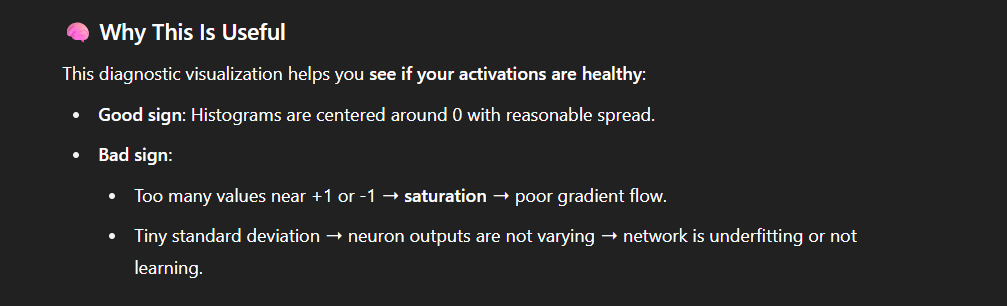

layer 2 (      Tanh): mean -0.00,  std 0.69, saturation 9.19%
layer 5 (      Tanh): mean +0.00,  std 0.70, saturation 9.78%
layer 8 (      Tanh): mean +0.00,  std 0.71, saturation 10.06%
layer 11 (      Tanh): mean -0.00,  std 0.72, saturation 10.47%
layer 14 (      Tanh): mean -0.00,  std 0.73, saturation 8.97%


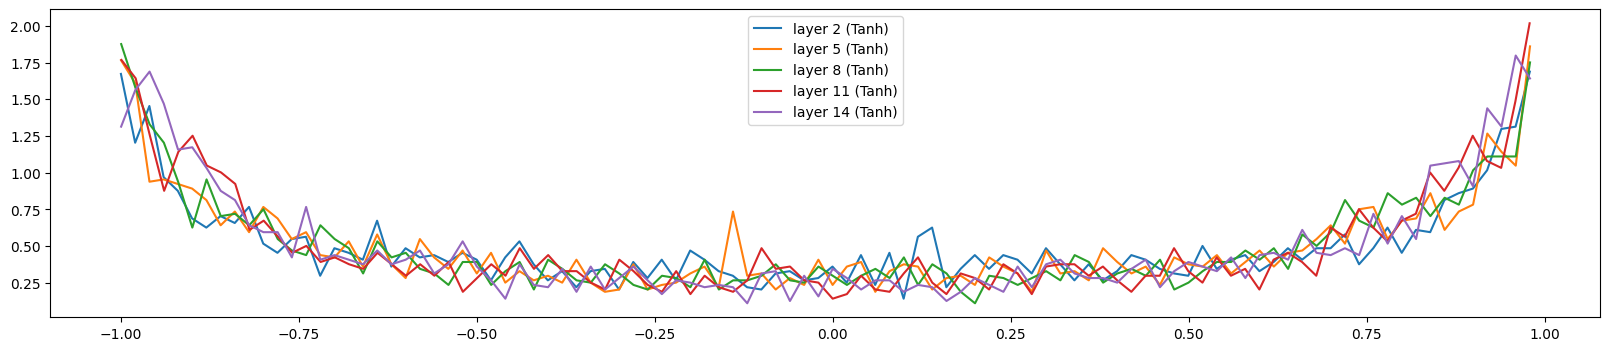

' saturation\nMeasures how many activations are close to -1 or +1, i.e., |t| > 0.97.\n\nHigh saturation means many neurons are in the flat part of the tanh curve → very low gradients, which can stall learning.\n\nRule of thumb:\n\n< 10% → very good\n\n10-30% → okay\n\n> 30% → caution\n\nYour values:\n\nLayer 1: 17.47% → a bit high\n\nLayers 3–9: ~6–8% → excellent\n'

In [56]:
# visualising the histograms of activation layers

plt.figure(figsize=(20,4))
legends =[]

for i , layer in enumerate(layers[:-1]):
  # excluding the last layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f,  std %.2f, saturation %.2f%%" % (i , layer.__class__.__name__ , t.mean() , t.std() , (t.abs() >0.97).float().mean()*100))
    hy , hx = torch.histogram(t , density=True)
    plt.plot(hx[:-1].detach() , hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.show()

''' saturation
Measures how many activations are close to -1 or +1, i.e., |t| > 0.97.

High saturation means many neurons are in the flat part of the tanh curve → very low gradients, which can stall learning.

Rule of thumb:

< 10% → very good

10-30% → okay

> 30% → caution

Your values:

Layer 1: 17.47% → a bit high

Layers 3–9: ~6–8% → excellent
'''

layer 2 (      Tanh): mean -0.000000,  std 3.576681e-03 
layer 5 (      Tanh): mean -0.000000,  std 3.487010e-03 
layer 8 (      Tanh): mean +0.000000,  std 3.396035e-03 
layer 11 (      Tanh): mean +0.000000,  std 3.221381e-03 
layer 14 (      Tanh): mean +0.000000,  std 3.178507e-03 


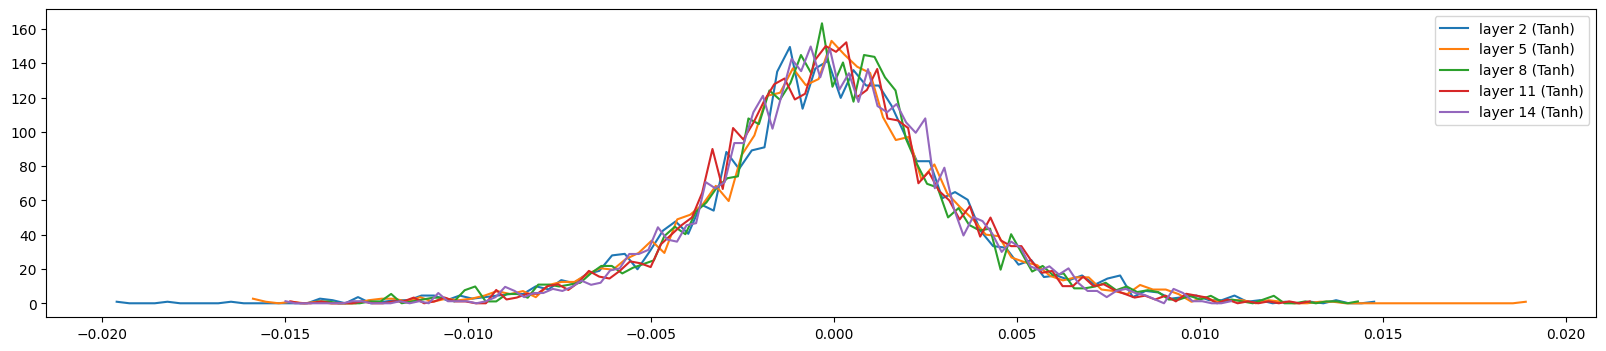

In [57]:
# visualising the histograms of activation layers
plt.figure(figsize=(20,4))
legends =[]

for i , layer in enumerate(layers[:-1]):
  # excluding the last layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+f,  std %e " % (i , layer.__class__.__name__ , t.mean() , t.std() ))
    hy , hx = torch.histogram(t , density=True)
    plt.plot(hx[:-1].detach() , hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.show()